# Audio Model for Driver Distraction Detection

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchaudio
import pandas as pd
import timm
import matplotlib.pyplot as plt
from IPython.display import Audio
from tqdm.notebook import tqdm
import audio_preprocessing
from os.path import join, isfile
from os import listdir

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Preprocessing

In [3]:
num_labels = 2
labels = ['clean_train', 'noise_train']
class_idx = [0, 1]

In [4]:
def get_file_paths_y(verbose=False):
    dir_paths = ["D:\data/MS-SNSD/train/" + label for label in labels]
    paths = [[join(dir_paths[i], f) for f in sorted(listdir(dir_paths[i])) if isfile(join(dir_paths[i], f))] for i in range(len(dir_paths))]
    y = []
    for i in range(num_labels):
        if verbose:
            print(f"Number of {labels[i]} files: {len(paths[i])}")
        for path in paths[i]:
            assert path[-3:] == "wav", f"{labels[i]} directory contains a non-waveform file: {path}"
        y += [class_idx[i]] * len(paths[i])
    paths = [x for i in range(len(paths)) for x in paths[i]]
    y = torch.tensor(y)
    return paths, y

In [5]:
def conform_frames(paths, verbose=False):
    # audio metadata is the same for every file, we have same number of frames and channels for every file
    metadata_0 = torchaudio.info(paths[0])
    num_frames_0 = metadata_0.num_frames
    if verbose:
        print(metadata_0)
    
    def metadata_eq(self, other):
        return self.sample_rate == other.sample_rate and self.num_frames == other.num_frames \
                and self.num_channels == other.num_channels and self.bits_per_sample == other.bits_per_sample \
                and self.encoding == other.encoding
    torchaudio.backend.common.AudioMetaData.__eq__ = metadata_eq
    for path in paths:
        metadata = torchaudio.info(path)
        if (metadata.num_frames != num_frames_0):
            if (metadata.num_frames > num_frames_0):
                # trim
                audio, sample_rate = torchaudio.load(path)
                audio = audio[:, :num_frames_0]
                torchaudio.save(path, audio, sample_rate)
            else:
                # pad
                audio, sample_rate = torchaudio.load(path)
                audio = torch.nn.functional.pad(audio, (0, num_frames_0 - metadata.num_frames))
                torchaudio.save(path, audio, sample_rate)
            metadata = torchaudio.info(path)


In [6]:
import soundfile

def conform_bits_per_sample(paths, verbose=False):
    # audio metadata is the same for every file, we have same number of frames and channels for every file
    metadata_0 = torchaudio.info(paths[0])
    bits_per_sample_0 = metadata_0.bits_per_sample
    if verbose:
        print(metadata_0)
    
    def metadata_eq(self, other):
        return self.sample_rate == other.sample_rate and self.num_frames == other.num_frames \
                and self.num_channels == other.num_channels and self.bits_per_sample == other.bits_per_sample \
                and self.encoding == other.encoding
    torchaudio.backend.common.AudioMetaData.__eq__ = metadata_eq
    for path in paths:
        metadata = torchaudio.info(path)
        data, samplerate = soundfile.read(path)
        if (metadata.bits_per_sample != bits_per_sample_0):
            soundfile.write(path, data, samplerate, subtype='PCM_16')


In [7]:
def check_metadata(paths, verbose=False):
    # audio metadata is the same for every file, we have same number of frames and channels for every file
    metadata_0 = torchaudio.info(paths[0])
    if verbose:
        print(metadata_0)
    def metadata_eq(self, other):
        return self.sample_rate == other.sample_rate and self.num_frames == other.num_frames \
                and self.num_channels == other.num_channels and self.bits_per_sample == other.bits_per_sample \
                and self.encoding == other.encoding
    torchaudio.backend.common.AudioMetaData.__eq__ = metadata_eq
    for path in paths:
        metadata = torchaudio.info(path)
        assert metadata == metadata_0, f"AudioMetaData for {path} is {metadata} while original is {metadata_0}"

In [8]:
import torch
import audio_preprocessing  # You'll need to import the relevant audio_preprocessing module

def preprocess(files):
    X = torch.empty((len(files), 1, 256, 256))
    for i, file in enumerate(files):
        waveform, _ = audio_preprocessing.load_wav(file)
        mel_spectrogram = audio_preprocessing.MEL_SPECTROGRAM(waveform)
        
        # Resize or pad the mel_spectrogram to match the target size [1, 256, 256]
        if mel_spectrogram.shape != (1, 256, 256):
            # Resize the image to match the target size
            mel_spectrogram = torch.nn.functional.interpolate(mel_spectrogram.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False)
            mel_spectrogram = mel_spectrogram.squeeze()  # Remove the added dimensions
        
        X[i] = mel_spectrogram
    return X


In [9]:
def display_example_preprocessing(wav_file):
    print(f"Preprocessing wav file: {wav_file}")
    waveform, sample_rate = audio_preprocessing.load_wav(wav_file)
    print(f"Sample Rate: {sample_rate}, # Frames: {waveform.shape[0]}")
    audio_preprocessing.play_audio(waveform, sample_rate)
    audio_preprocessing.plot_waveform(waveform, sample_rate)
    mel_spectrogram = audio_preprocessing.MEL_SPECTROGRAM(waveform)
    print(f"Spectogram has shape (n_mels, sequence_length): ({mel_spectrogram.shape[0]}, {mel_spectrogram.shape[1]})")
    audio_preprocessing.plot_spectrogram(mel_spectrogram)

In [11]:
paths, y = get_file_paths_y(verbose=False)
torchaudio.set_audio_backend('soundfile')
conform_frames(paths, verbose=True)

AudioMetaData(sample_rate=16000, num_frames=46240, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [12]:
conform_bits_per_sample(paths, verbose=True)
check_metadata(paths, verbose=True)

AudioMetaData(sample_rate=16000, num_frames=46240, num_channels=1, bits_per_sample=16, encoding=PCM_S)
AudioMetaData(sample_rate=16000, num_frames=46240, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [13]:
X = preprocess(paths)

Preprocessing wav file: D:\data/MS-SNSD/train/clean_train\p234_001.wav
Sample Rate: 16000, # Frames: 46240


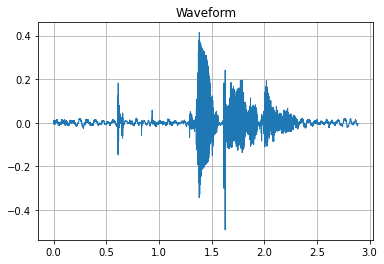

Spectogram has shape (n_mels, sequence_length): (256, 36)


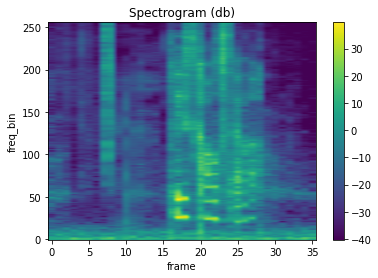

In [14]:
display_example_preprocessing(paths[0])

In [15]:
class CustomDataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = spectrograms
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

## Model

### CNN

In [16]:
model = timm.create_model("resnet18", pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=50, bias=True)
model = model.to(device)
summary(model, (1,256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
          Identity-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
          Identity-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
       BasicBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

### Optimizer & Loss

In [17]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lossfn = nn.CrossEntropyLoss()

## Training

In [18]:
def train(train_loader, num_epochs):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for x, y in tqdm(train_loader):
            x = x.to(device)
            y = y.to(device)

            pred = model(x)
            loss = lossfn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            epoch_loss += loss.item()
        print(f"Epoch #{epoch+1} loss: {epoch_loss / len(train_loader)}")
    torch.save(model.state_dict(), "model.pt")
    return losses

In [19]:
def valid(valid_loader):
    model.eval()
    losses = []
    correct = 0
    for x,y in tqdm(valid_loader):
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = lossfn(pred, y)
        top1pred = torch.argmax(pred, dim=1)
        losses.append(loss.item())
        correct += torch.sum(top1pred == y)
    print(f"Valid Loss: {np.mean(np.array(losses))}, Acc: {correct/len(valid_loader.dataset)}")

In [20]:
def plot_losses(losses):
    plt.figure()
    plt.plot(losses)
    plt.title("Training Losses")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss ")
    plt.show()

In [21]:
idx = np.arange(len(X))
np.random.shuffle(idx)
train_idx = idx[:int(len(X) * .8)]
valid_idx = idx[int(len(X) * .8):]
X_train = X[train_idx]
X_valid = X[valid_idx]
y_train = y[train_idx]
y_valid = y[valid_idx]

  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #1 loss: 0.0902363473109694


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #2 loss: 0.024023129825705293


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #3 loss: 0.019070544937993726


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #4 loss: 0.015615976042037792


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #5 loss: 0.01451543958205489


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #6 loss: 0.01173763119161735


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #7 loss: 0.010333906946752975


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #8 loss: 0.00828200783878787


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #9 loss: 0.008778129776836821


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #10 loss: 0.008508648261263798


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #11 loss: 0.008412078622750195


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #12 loss: 0.007756150092006577


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #13 loss: 0.00628930473878574


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #14 loss: 0.006687822111742491


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #15 loss: 0.006017229152126897


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #16 loss: 0.005928821011895157


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #17 loss: 0.0060289837070555885


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #18 loss: 0.005571309553974081


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #19 loss: 0.005807997777952617


  0%|          | 0/1161 [00:00<?, ?it/s]

Epoch #20 loss: 0.005128768453902799


  0%|          | 0/291 [00:00<?, ?it/s]

Valid Loss: 0.007059776246573902, Acc: 0.9982762336730957


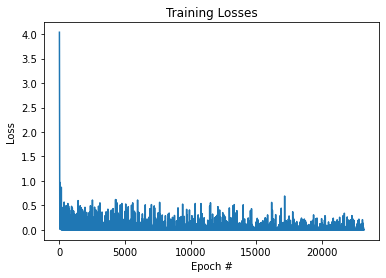

In [22]:
trainset = CustomDataset(X_train, y_train)
validset = CustomDataset(X_valid, y_valid)
train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
valid_loader = DataLoader(validset, batch_size=16)
losses = train(train_loader, num_epochs=20)
valid(valid_loader)

plot_losses(losses)

## Loading Trained Model

In [23]:
model.load_state_dict(torch.load("model.pt", map_location=device))
model.eval()

testset = CustomDataset(X_valid, y_valid)
test_loader = DataLoader(testset, batch_size=16)
valid(test_loader)

  0%|          | 0/291 [00:00<?, ?it/s]

Valid Loss: 0.007059776246573902, Acc: 0.9982762336730957
